# M5 Project

In this project you will solve a robot localization problem using the particle filtering technique. The problem is illustrated in the figures below. You will have two types of robots: the pacman (triangle) and the ghost (pentagon). The pacman can measure its distance to the landmarks (blue circles), but the ghost can only measure its distance to the pacman. The environment is cyclic, so when the pacman or the ghost cross one of the sides, it appears in the opposite side. You will have to code the downweigh and resample steps of the particle filtering code provided as starting point.

<img src="m5project1.png" width="400"/><img src="m5project2.png" width="400"/><img src="m5project3.png" width="400"/>

An initial version of the code with the problem specification (below) and a report template (at the bottom) are available in this notebook. Deliverables are the final code (non-functioning code is worth 0 points) and the report.

You must implement:
- downweigh and resample steps for the pacman (20pts)
- downweigh and resample steps for the ghost (20pts)

For your solution, describe the:
- how you updated the ghost particles without having the real location of the pacman (20pts)
- which other alternatives have you considered, and why you decided not to use them (10pts)

Run your code at least 10 times and:
- compare the uncertainty in the location of the pacman and the ghost over time (15pts)
- explain what causes the ghost particles to concentrate in a well-defined cluster (15pts) - see the rightmost picture above

# Implementation

In this project, you can only modify the last cell of code. The area that can be modified is marked between the comments "YOUR CODE STARTS HERE" and "YOUR CODE ENDS HERE".

In [23]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# world configuration
landmarks  = [[20.0, 20.0], [80.0, 80.0], [20.0, 80.0], [80.0, 20.0]]
world_size = 100.0

# generic robot implementation
class robot:
    def __init__(self):
        # initialise robot with random location and orientation
        self.x = random.random() * world_size
        self.y = random.random() * world_size
        self.orientation = random.random() * 2.0 * math.pi
        
        self.forward_noise = 0.0
        self.turn_noise    = 0.0
        self.sense_noise   = 0.0
    
    def set(self, new_x, new_y, new_orientation):
        if new_x < 0 or new_x >= world_size:
            raise ValueError('X coordinate out of bound')
        if new_y < 0 or new_y >= world_size:
            raise ValueError('Y coordinate out of bound')
        if new_orientation < 0 or new_orientation >= 2 * math.pi:
            raise ValueError('Orientation must be in [0..2pi]')
        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation)

    def set_noise(self, new_f_noise, new_t_noise, new_s_noise):
        self.forward_noise = float(new_f_noise);
        self.turn_noise    = float(new_t_noise);
        self.sense_noise   = float(new_s_noise);
    
    # apply noisy movement to robot
    def new_position(self, turn, forward):
        if forward < 0:
            raise ValueError('Robot cant move backwards')
        
        # turn, and add randomness to the turning command
        orientation = self.orientation + float(turn) + random.gauss(0.0, self.turn_noise)
        orientation %= 2 * math.pi
        
        # move, and add randomness to the motion command
        dist = float(forward) + random.gauss(0.0, self.forward_noise)
        x = self.x + (math.cos(orientation) * dist)
        y = self.y + (math.sin(orientation) * dist)
        x %= world_size    # cyclic truncate
        y %= world_size

        return x, y, orientation
    
    # model noise using Gaussians
    def Gaussian(self, mu, sigma, x):
        # calculates the probability of x for 1-dim Gaussian with mean mu and var. sigma
        return math.exp(- ((mu - x) ** 2) / (sigma ** 2) / 2.0) / math.sqrt(2.0 * math.pi * (sigma ** 2))
    
# PacMan class
class pacman(robot):
    # the PacMan can sense its location using the landmarks
    def sense(self):
        Z = []
        for i in range(len(landmarks)):
            dist = math.sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            dist += random.gauss(0.0, self.sense_noise)
            Z.append(dist)
        return Z

    # calculates how likely a measurement should be
    def measurement_prob(self, measurement):
        prob = 1.0
        for i in range(len(landmarks)):
            dist = math.sqrt((self.x - landmarks[i][0]) ** 2 + (self.y - landmarks[i][1]) ** 2)
            prob *= self.Gaussian(dist, self.sense_noise, measurement[i])
        return prob

    def move(self, turn, forward):
        x, y, orientation = self.new_position(turn, forward)
        res = pacman()
        res.set(x, y, orientation)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res

# Ghost class
class ghost(robot):
    # the PacMan ("mypacman") can sense its distance to the ghost
    def sense(self, mypacman):
        Z = math.sqrt((self.x - mypacman.x) ** 2 + (self.y - mypacman.y) ** 2) + random.gauss(0.0, self.sense_noise)
        return Z

    # calculates how likely a measurement should be
    def measurement_prob(self, measurement, mypacman):
        dist = math.sqrt((self.x - mypacman.x) ** 2 + (self.y - mypacman.y) ** 2)
        prob = self.Gaussian(dist, self.sense_noise, measurement)
        return prob

    def move(self, turn, forward):
        x, y, orientation = self.new_position(turn, forward)
        res = ghost()
        res.set(x, y, orientation)
        res.set_noise(self.forward_noise, self.turn_noise, self.sense_noise)
        return res

In [27]:
# world visualization with the distribution of particles
def show_belief(mypacman, pacman_particles, myghost, ghost_particles):
    plt.rcParams["figure.figsize"] = (5,5)

    for p in pacman_particles:
        plt.plot(p.x, p.y, marker=(3, 0, 180.0*p.orientation/math.pi), markerfacecolor='red', markersize=10, markeredgewidth=0.0, alpha=.3, linestyle='None')

    plt.plot(mypacman.x, mypacman.y, marker=(3, 0, 180.0*mypacman.orientation/math.pi), markerfacecolor='black', markersize=20, markeredgewidth=0.0, linestyle='None')

    for p in ghost_particles:
        plt.plot(p.x, p.y, marker=(5, 0, 180.0*p.orientation/math.pi), markerfacecolor='green', markersize=10, markeredgewidth=0.0, alpha=.3, linestyle='None')

    plt.plot(myghost.x, myghost.y, marker=(5, 0, 180.0*myghost.orientation/math.pi), markerfacecolor='black', markersize=20, markeredgewidth=0.0, linestyle='None')

    for x, y in landmarks:
          plt.plot(x, y, marker='o', markersize=20, markeredgewidth=2.0, markerfacecolor='None', markeredgecolor='blue')

    plt.xlim([0,100])
    plt.ylim([0,100])

    plt.show()

# measure the proximity between the real location and the distribution of particles
def eval(r, p):
    s = 0.0;
    for i in range(len(p)):
        dx = (p[i].x - r.x + (world_size/2.0)) % world_size - (world_size/2.0)
        dy = (p[i].y - r.y + (world_size/2.0)) % world_size - (world_size/2.0)
        err = math.sqrt(dx * dx + dy * dy)
        s += err
    return s / float(len(p))

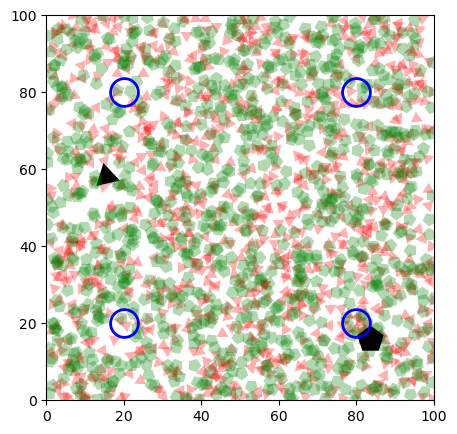

Average pacman distance: 39.07501672838592
Average ghost distance: 37.64436619181839


In [29]:
# pacman/ghost initialization
forward_noise = 3.0 
turn_noise = 0.05
sense_noise = 3.0

mypacman = pacman()
mypacman.set_noise(forward_noise, turn_noise, sense_noise)

myghost = ghost()
myghost.set_noise(forward_noise, turn_noise, sense_noise)

# particle distribution
N = 1000 # number of particles
T = 10   # number of moves

# initialise randomly guessed particles for pacman and ghost
p = []
g = []
for i in range(N):
    x = pacman()
    x.set_noise(forward_noise, turn_noise, sense_noise)
    p.append(x)
    x = ghost()
    x.set_noise(forward_noise, turn_noise, sense_noise)
    g.append(x)

show_belief(mypacman, p, myghost, g)

print("Average pacman distance:", eval(mypacman, p))
print("Average ghost distance:", eval(myghost, g))


Turn #1


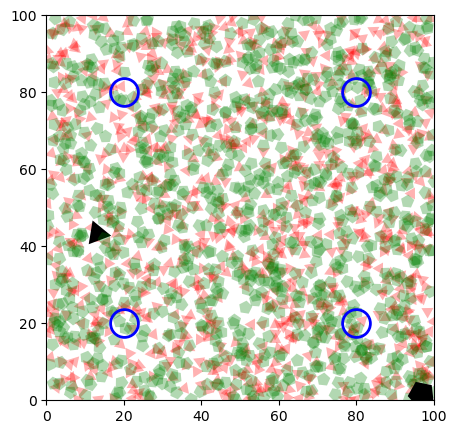

Average pacman distance before resample: 38.86071378452382
Average ghost distance before resample: 38.24968884899991


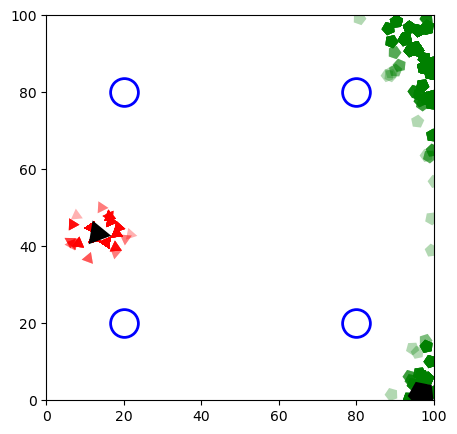

Average pacman distance after resample: 2.569522307357242
Average ghost distance after resample: 11.50609716087064

Turn #2


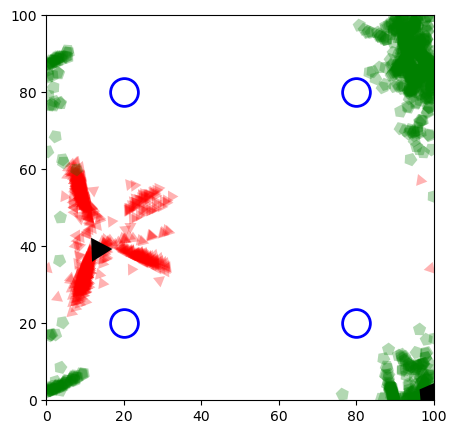

Average pacman distance before resample: 11.46115593701697
Average ghost distance before resample: 12.810501993836864


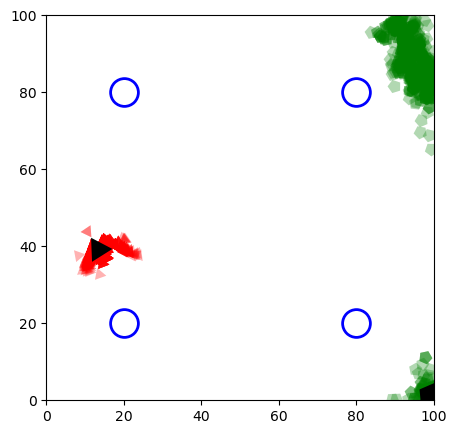

Average pacman distance after resample: 3.140640533684152
Average ghost distance after resample: 12.984502762304308

Turn #3


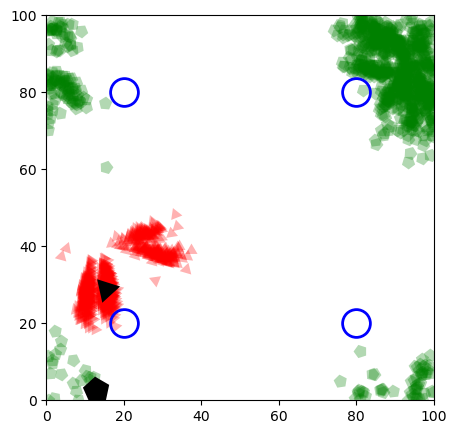

Average pacman distance before resample: 7.48575612271411
Average ghost distance before resample: 27.055208778843348


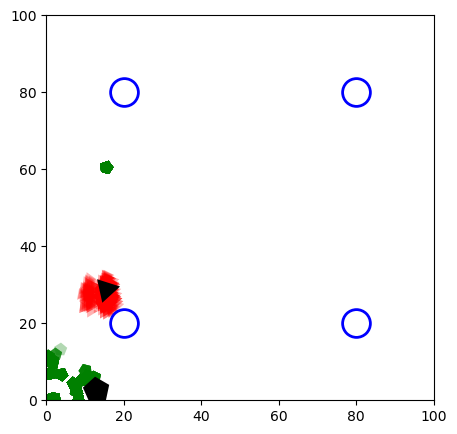

Average pacman distance after resample: 2.176960687016935
Average ghost distance after resample: 11.371549064950882

Turn #4


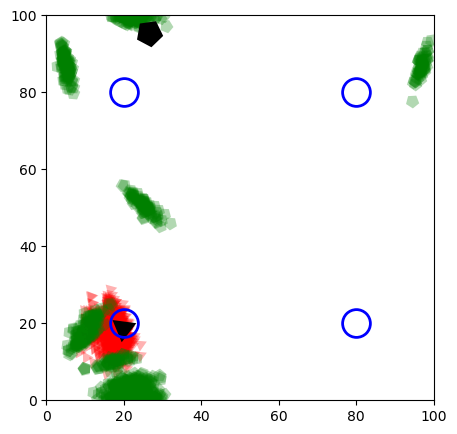

Average pacman distance before resample: 4.192228315159173
Average ghost distance before resample: 18.640379082110428


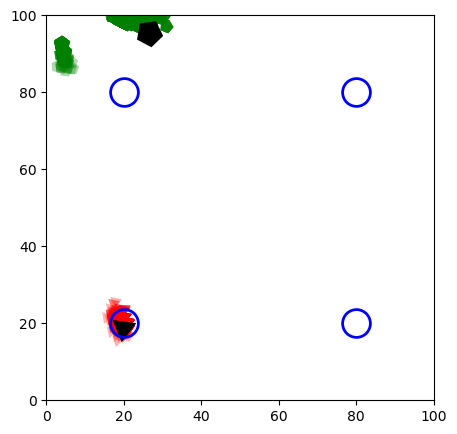

Average pacman distance after resample: 2.105472288957628
Average ghost distance after resample: 9.606643744721435

Turn #5


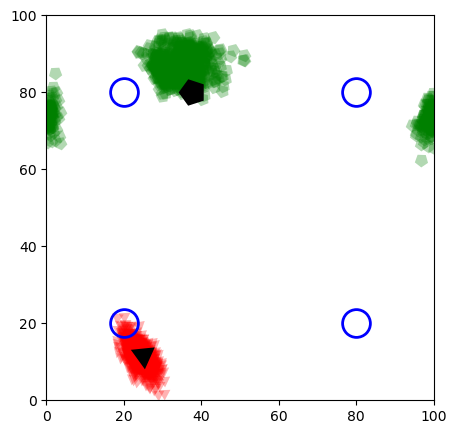

Average pacman distance before resample: 3.2381394073257272
Average ghost distance before resample: 14.953979839075231


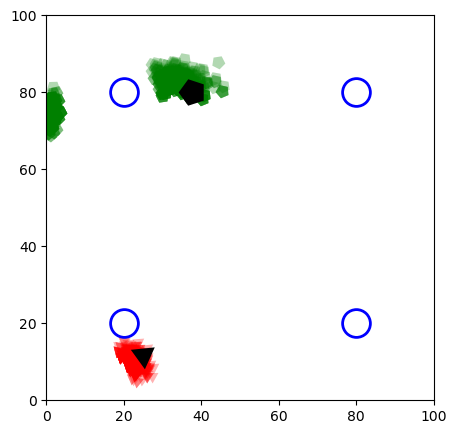

Average pacman distance after resample: 3.3226393360411204
Average ghost distance after resample: 19.88598741229208

Turn #6


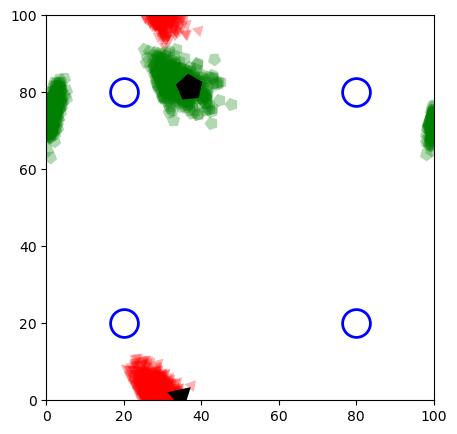

Average pacman distance before resample: 7.015257639546339
Average ghost distance before resample: 19.619893863403266


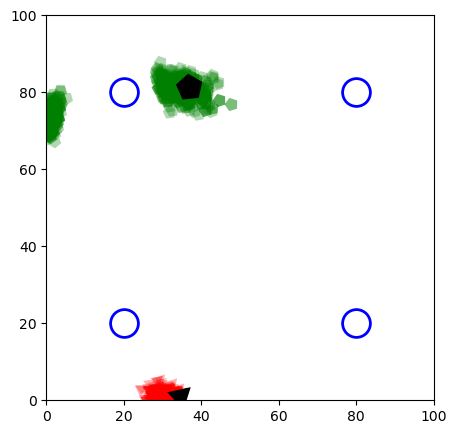

Average pacman distance after resample: 4.201509519883895
Average ghost distance after resample: 18.09990353345353

Turn #7


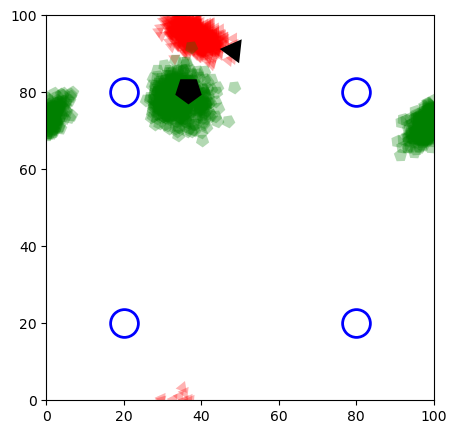

Average pacman distance before resample: 10.9300249474671
Average ghost distance before resample: 19.716896737258917


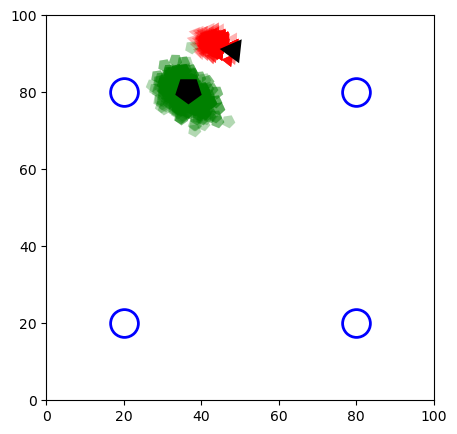

Average pacman distance after resample: 5.019946100767368
Average ghost distance after resample: 3.6723666133277444

Turn #8


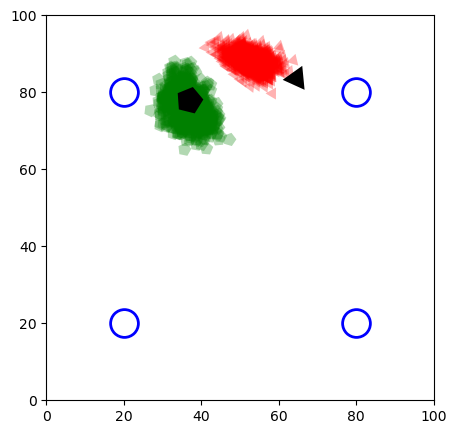

Average pacman distance before resample: 12.79859008733222
Average ghost distance before resample: 4.642205209499282


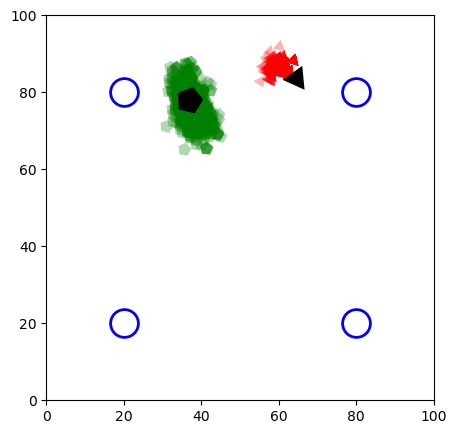

Average pacman distance after resample: 4.599879002230709
Average ghost distance after resample: 4.173767607135986

Turn #9


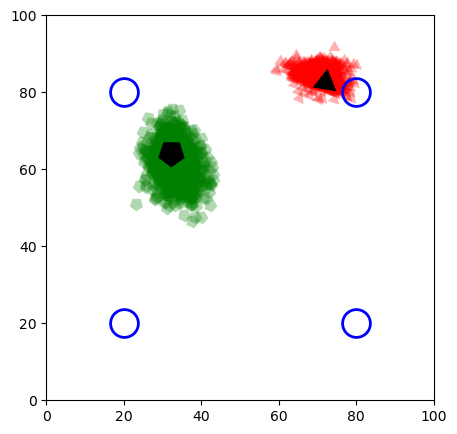

Average pacman distance before resample: 3.9126695065408312
Average ghost distance before resample: 5.615666226464272


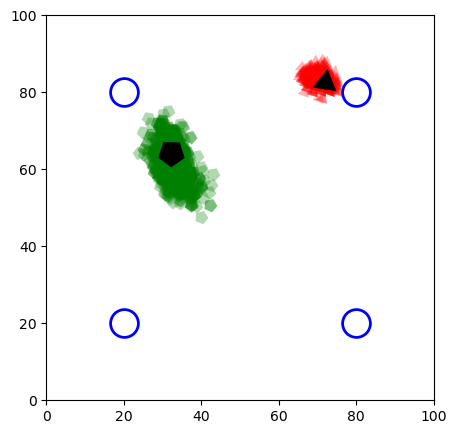

Average pacman distance after resample: 2.3879065515749245
Average ghost distance after resample: 5.037544724011071

Turn #10


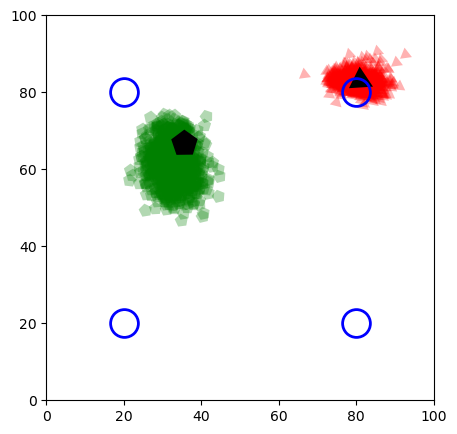

Average pacman distance before resample: 3.353962250191954
Average ghost distance before resample: 7.717806304821659


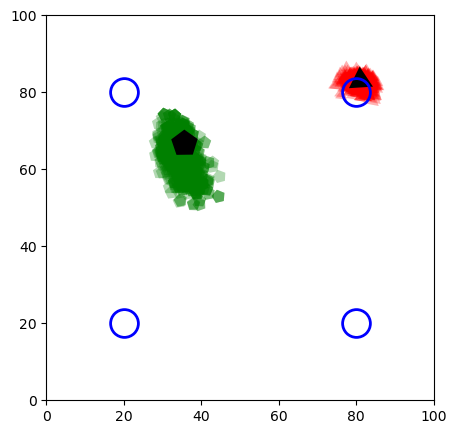

Average pacman distance after resample: 2.1238068534829746
Average ghost distance after resample: 5.590181556649311


In [31]:
for turn in range(T):
    print('\nTurn #{}'.format(turn+1))

    # real pacman movement
    # turn 0.1 and move 10 meters
    mypacman = mypacman.move(0.2, 10.0)

    # real move for ghost (random)
    gturn = (random.random()-0.5)*(math.pi/2.0) # random angle in [-45,45]
    gdist = random.random()*20.0           # random distance in [0,20]
    myghost = myghost.move(gturn, gdist)

    # elapse time
    # move particles using the same movement made by robot
    p2 = []
    g2 = []
    for i in range(N):
        p2.append(p[i].move(0.2, 10.0))
        g2.append(g[i].move(gturn, gdist))
    p = p2
    g = g2

    show_belief(mypacman, p, myghost, g)
    print("Average pacman distance before resample:", eval(mypacman, p))
    print("Average ghost distance before resample:", eval(myghost, g))

    # observe
    ZP = mypacman.sense()        # noisy measurement of the distance between the pacman and the landmarks
    ZG = myghost.sense(mypacman) # noisy measurement of the distance between the pacman and the ghost

    ###################################
    ###################################
    ###################################
    ###### YOUR CODE STARTS HERE ######
    ###################################
    ###################################
    ###################################

# downweight and resample steps for the pacman and ghost particles

    # downweight and resample pacman and ghost particles here - check the Particle Filtering lecture for an example

    # particles do not know the real location of the pacman and the ghost, so you cannot access "mypacman" and "myghost" in here
    # remember that you can still use p and g, which can be used to estimate the location of the pacman and the ghost

    # you should use the obtained measurements from the sensors to update the particles
    # - ZP contains the observed distances between the pacman and the landmarks
    # - ZG is the observed distance between the pacman and the ghost

    # update pacman
    pacman_weights = []
    for particle in p:
        pacman_weights.append(particle.measurement_prob(ZP))

    # normalize weights
    pacman_weights = [w / sum(pacman_weights) for w in pacman_weights]

    # pacman resample
    p_resampled = []
    index = int(random.random() * N)
    beta = 0.0
    mw = max(pacman_weights)
    for i in range(N):
        beta += random.random() * 2.0 * mw
        while beta > pacman_weights[index]:
            beta -= pacman_weights[index]
            index = (index + 1) % N
        p_resampled.append(p[index])
    p = p_resampled

    # update ghost
    ghost_weights = []
    for particle in g:
        ghost_weights.append(particle.measurement_prob(ZG, mypacman))

    # normalize weights
    ghost_weights = [w / sum(ghost_weights) for w in ghost_weights]

    # resample ghost 
    g_resampled = []
    index = int(random.random() * N)
    beta = 0.0
    mw = max(ghost_weights)
    for i in range(N):
        beta += random.random() * 2.0 * mw
        while beta > ghost_weights[index]:
            beta -= ghost_weights[index]
            index = (index + 1) % N
        g_resampled.append(g[index])
    g = g_resampled



    



    #################################
    #################################
    #################################
    ###### YOUR CODE ENDS HERE ######
    #################################
    #################################
    #################################

    show_belief(mypacman, p, myghost, g)
    print("Average pacman distance after resample:", eval(mypacman, p))
    print("Average ghost distance after resample:", eval(myghost, g))

# Report template

## Solution description

How you updated the ghost particles without having the real location of the pacman?

The ghost particles are updated based on the observed distance between the ghost and packman. Since each ghost particle can sense its distance to pacman, that measurement was used to calculate the probability of the particle's location. That probability is then used to weigh the particles during the resampling step.

Which other alternatives have you considered, and why you decided not to use them?

One alternative I considered was to use a Kalman filter instead of particle filtering. However, Kalman filters assume Gaussian noise and linear relationships, which may not be suitable for the cyclic and nonlinear nature of the test environment.

## Experimental results

Here I compare the uncertainty in the location of the pacman and the ghost over time ...

The ghost particles tend to concentrate in a well-defined cluster when ...

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Scelerisque eu ultrices vitae auctor eu augue. Tempor nec feugiat nisl pretium fusce. Sed cras ornare arcu dui vivamus arcu felis. Leo duis ut diam quam nulla porttitor massa. Lacus vestibulum sed arcu non odio euismod lacinia. Augue neque gravida in fermentum et sollicitudin ac orci. Habitant morbi tristique senectus et. Ut tellus elementum sagittis vitae et. Diam vulputate ut pharetra sit amet. Nisl nunc mi ipsum faucibus vitae aliquet nec ullamcorper sit. Nec ullamcorper sit amet risus nullam eget felis. Fringilla ut morbi tincidunt augue interdum velit euismod. Facilisis magna etiam tempor orci eu lobortis.